# Notebook Overview
- **Objective**: This notebook aims to project air quality index (AQI) trends into the future and analyze the impact of these trends on state park attendance. By leveraging time series modeling, we seek to quantify how future increases in smoke days could reduce park revenue and inform policy decisions for mitigating these impacts.
  
- **Data Sources**:
    - Historical AQI data was collected through the US Environmental Protection Agency (EPA) Air Quality System (AQS) API.
    - Florida State Parks attendance data was collected from [insert source, e.g., Florida State Parks reports].
    - Behavior data on reduced outdoor activity due to poor AQI  data was sourced from [this Nature Data paper on human perception of and response to wildfire smoke](https://www.nature.com/articles/s41597-019-0251-y)
    - The analysis integrates these datasets to model relationships between AQI levels and attendance patterns.

- **Modeling Approach**: 
   - We employ the **ARIMA (AutoRegressive Integrated Moving Average)** model to project future AQI trends. 
   - ARIMA was selected because:
     1. **Suitability for Non-Stationary Data**: ARIMA effectively models non-stationary time series data, where trends and noise patterns vary over time, as is common with AQI data influenced by seasonal wildfire activity.
     2. **Forecasting Capability**: ARIMA is well-suited for forecasting future values based on historical trends, which aligns with our objective of projecting AQI levels into the next 25 years.
     3. **Flexibility**: By adjusting the order parameters (p, d, q), ARIMA can adapt to various time series patterns, including those with autoregressive behavior or moving average structures.

- **Purpose**: The insights from this model will help estimate reductions in park attendance due to worsening air quality and their associated economic impacts. The results aim to inform city and state planners and policymakers in Tallahassee about potential budget shortfalls and funding alternatives for state parks.

## Outline
- Imports
- Constants
- Load Data
- Prepare AQI data for modeling
- Model AQI Categories
- Incorporate Parks attendance & economic data
- Incorporate Behavior Data

## Imports

In [1]:
import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from statsmodels.tsa.arima.model import ARIMA

## Constants

In [2]:
input_directory  = r"C:\Users\clark.roll\python coding\code_personal\Data512\Course Project\Data Analysis and Modeling\input_files"
viz_directory    = r"C:\Users\clark.roll\python coding\code_personal\Data512\Course Project\Data Analysis and Modeling\visualizations"
output_directory = r"C:\Users\clark.roll\python coding\code_personal\Data512\Course Project\Data Analysis and Modeling\output_files"

In [3]:
AQI_CATEGORIES = {
    'Good':                        {'color': 'green',   'threshold_min':0,   'threshold_max':50},
    'Moderate':                    {'color': 'yellow',  'threshold_min':51,  'threshold_max':100},
    'Unhealthy for sensitive grps':{'color': 'orange',  'threshold_min':101, 'threshold_max':150},
    'Unhealthy':                   {'color': 'red',     'threshold_min':151, 'threshold_max':200},
    'Very unhealthy':              {'color': 'purple',  'threshold_min':201, 'threshold_max':300},
    'Hazardous':                   {'color': 'maroon',  'threshold_min':301, 'threshold_max':1000}
}

## Load Data

In [4]:
survey                 = 'activity_survey_subset.csv'
fullYear_daily_aqi     = 'AQI_fullYear_daily_avg.csv'
seasonal_daily_aqi     = 'AQI_seasonal_daily_avg.csv'
parks                  = 'parks_data.csv'
survey_thresh          = 'activity_reduction_perc_by_AQI.csv'

# Full paths for each file
survey_path        = os.path.join(input_directory, survey)
year_aqi_path      = os.path.join(input_directory, fullYear_daily_aqi)
szn_aqi_path       = os.path.join(input_directory, seasonal_daily_aqi)
parks_path         = os.path.join(input_directory, parks)
beh_thresh_path    = os.path.join(input_directory, survey_thresh)

# load dataframes
survey_df        = pd.read_csv(survey_path)
beh_thresh_df    = pd.read_csv(beh_thresh_path)
aqi_y_df         = pd.read_csv(year_aqi_path)
aqi_s_df         = pd.read_csv(szn_aqi_path)
parks_df         = pd.read_csv(parks_path)

## Define Functions

In [5]:
def gen_png_savepath(filename:str):
    save_path = os.path.join(viz_directory, filename)
    return save_path

def categorize_aqi(aqi_value: float) -> str:
    """
    Categorize an AQI value based on predefined AQI categories.
    
    Parameters
    ----------
    aqi_value : float
        The Air Quality Index (AQI) value to categorize.
    
    Returns
    -------
    str
        The category name corresponding to the AQI value.
    """
    for category, thresholds in AQI_CATEGORIES.items():
        if thresholds['threshold_min'] <= aqi_value <= thresholds['threshold_max']:
            return category
    return "Unknown"

## Prepare AQI data for modeling

In [6]:
aqi_y_df.rename(columns={"date_local":"date"}, inplace=True)

# Convert the 'date' column to datetime
aqi_y_df['date'] = pd.to_datetime(aqi_y_df['date'], errors='coerce')
# Extract year from the 'date' column
aqi_y_df['year'] = aqi_y_df['date'].dt.year
# Convert 'aqi' column to float and round to the nearest integer
aqi_y_df['aqi'] = aqi_y_df['aqi'].astype(float).round()

Apply the AQI categories to the measurement

In [7]:
daily_aqi_long = aqi_y_df.copy()

# Apply the function to the dataframe
daily_aqi_long['aqi_category'] = daily_aqi_long['aqi'].apply(categorize_aqi)
daily_aqi_long

,date,aqi,year,aqi_category
0,1998-01-01,6.0,1998,Good
1,1998-01-02,10.0,1998,Good
2,1998-01-03,11.0,1998,Good
3,1998-01-04,10.0,1998,Good
4,1998-01-05,11.0,1998,Good
...,...,...,...,...
8733,2021-12-27,25.0,2021,Good
8734,2021-12-28,28.0,2021,Good
8735,2021-12-29,36.0,2021,Good
8736,2021-12-30,35.0,2021,Good


Get counts of days in AQI categories by year because we want to be able to predict the number of days in each category per year

In [8]:
# Group by year and category, then count occurrences
annual_aqi_long = daily_aqi_long.groupby(['year', 'aqi_category']).size().reset_index(name='count')

# Pivot the table to have categories as columns
annual_aqi_wide = annual_aqi_long.pivot(index='year', columns='aqi_category', values='count').fillna(0).astype(int)

make sure year is the index

In [9]:
# Drop the index level of column names
annual_aqi_wide.columns.name = None
annual_aqi_wide = annual_aqi_wide.reset_index()

In [10]:
# Ensure 'year' is the index and set it as a datetime index with Year Start frequency
annual_aqi_wide["year"] = pd.to_datetime(annual_aqi_wide["year"], format="%Y")
annual_aqi_wide.set_index("year", inplace=True)
annual_aqi_wide.index.freq = "YS"

In [11]:
annual_aqi_wide

,Good,Moderate,Unhealthy for sensitive grps
year,,,
1998-01-01,331,28,0
1999-01-01,311,52,2
2000-01-01,306,54,3
2001-01-01,329,36,0
2002-01-01,335,30,0
2003-01-01,307,56,2
2004-01-01,245,118,2
2005-01-01,238,125,2
2006-01-01,229,136,0


## Modeling

- **Objective**: The goal of the modeling step is to predict the number of days in each AQI category (e.g., Good, Moderate, Unhealthy) over the next 25 years. By projecting the distribution of AQI categories, we can assess the frequency of smoke-impacted days and their potential effects on state park attendance.

- **Approach**:
  - We use the **ARIMA (AutoRegressive Integrated Moving Average)** model to forecast future trends for each AQI category separately.
  - ARIMA is run multiple times, once for each AQI category, allowing us to capture the unique patterns and trends associated with each classification.
  - After obtaining forecasts for individual categories, the results are combined to create a comprehensive picture of future AQI distributions.

- **Why This Method**:
  - By modeling each AQI category independently, we can account for differences in their historical trends (e.g., an increasing number of Unhealthy days versus relatively stable Good days).
  - Combining forecasts provides a more granular understanding of the future air quality landscape and its impact on behavior and economic outcomes.

- **Outcome**: The aggregated results provide insights into how air quality will evolve over time and its implications for outdoor activities, enabling targeted recommendations for policy 
  nd planning.


In [12]:
model_df = annual_aqi_wide.copy()

In [13]:
# Initialize dictionaries for models and forecasts
arima_models = {}
forecasts = {}

for category in model_df.columns:
    # Fit ARIMA model for the category
    model = ARIMA(model_df[category], order=(1, 1, 0))  # Adjust order as needed
    arima_fitted = model.fit()

    # Forecast for the next 20 years
    forecast = arima_fitted.get_forecast(steps=20)
    forecast_summary = forecast.summary_frame(alpha=0.05)

    # Generate forecast dates
    forecast_dates = pd.date_range(
        start=model_df.index[-1] + pd.DateOffset(years=1),
        periods=20,
        freq="YS"
    )

    # Store the forecast data
    forecasts[category] = forecast_summary

### work with the forecasting data

In [14]:
# Check the structure of each forecast in the dictionary
for category, forecast in forecasts.items():
    print(f"{category}: {forecast.columns}")

Good: Index(['mean', 'mean_se', 'mean_ci_lower', 'mean_ci_upper'], dtype='object', name='Good')
Moderate: Index(['mean', 'mean_se', 'mean_ci_lower', 'mean_ci_upper'], dtype='object', name='Moderate')
Unhealthy for sensitive grps: Index(['mean', 'mean_se', 'mean_ci_lower', 'mean_ci_upper'], dtype='object', name='Unhealthy for sensitive grps')


In [15]:
# Combine forecasts into a single dataframe
combined_forecast = pd.concat(forecasts, axis=1)

combined_forecast.columns = pd.MultiIndex.from_tuples(
    [(category, col) for category in forecasts.keys() for col in ["mean", "mean_se", "mean_ci_lower", "mean_ci_upper"]]
)

# save the forecasted data to csv
combined_forecast.to_csv('aqi_category_forecasts.csv')

In [16]:
# Add totals for each year across all categories
combined_forecast['Total Days'] = combined_forecast.xs('mean', axis=1, level=1).sum(axis=1)

# Calculate yearly trends for key categories
category_trends = combined_forecast.xs('mean', axis=1, level=1)

### View the model

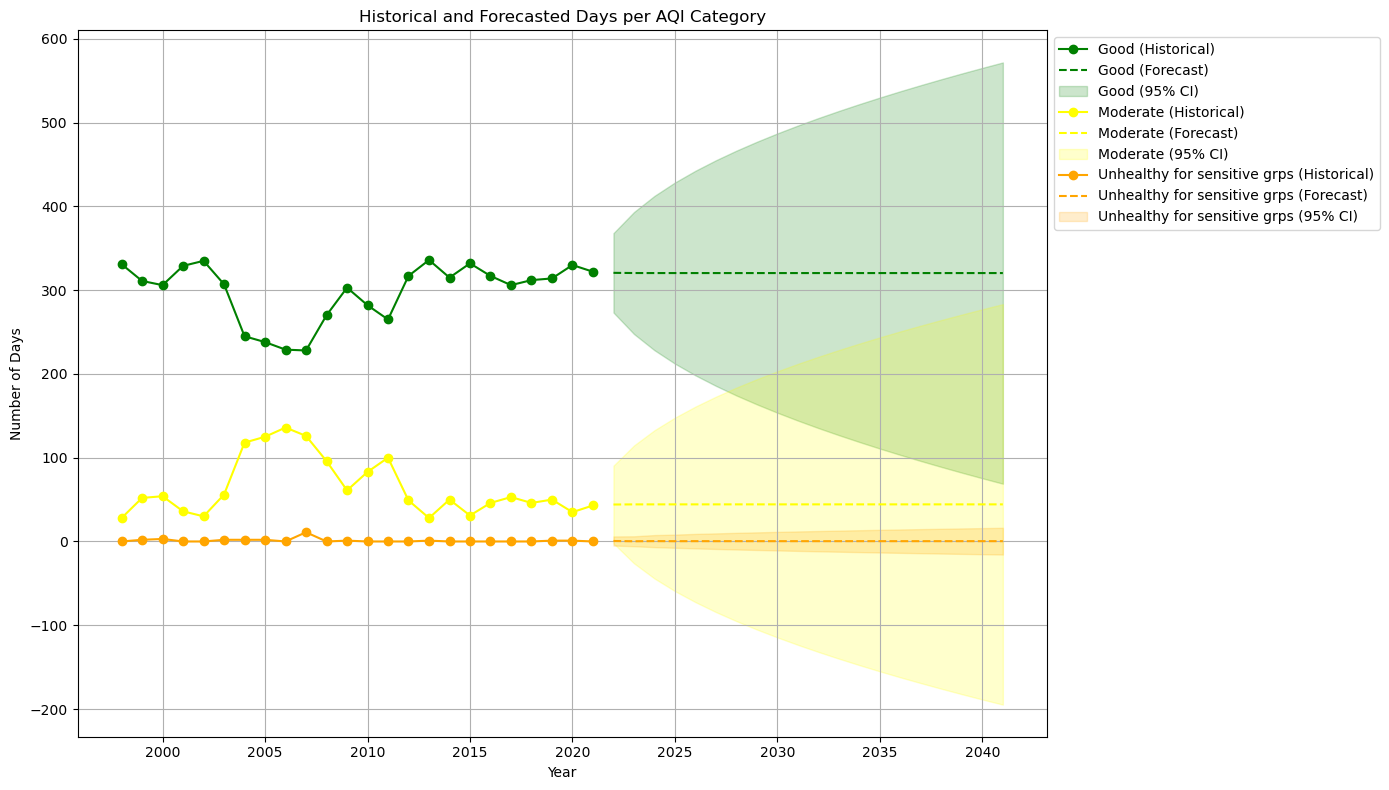

In [17]:
# Create the plot
plt.figure(figsize=(14, 8))

for category in model_df.columns:
    # Get the color from AQI_CATEGORIES
    color = AQI_CATEGORIES[category]['color']

    # Historical data
    plt.plot(
        model_df.index,
        model_df[category],
        label=f"{category} (Historical)",
        marker="o",
        color=color
    )

    # Forecasted data
    forecast_summary = forecasts[category]
    forecast_dates = pd.date_range(
        start=model_df.index[-1] + pd.DateOffset(years=1),
        periods=20,
        freq="YS"
    )
    plt.plot(
        forecast_dates,
        forecast_summary["mean"],
        label=f"{category} (Forecast)",
        linestyle="--",
        color=color
    )
    plt.fill_between(
        forecast_dates,
        forecast_summary["mean_ci_lower"],
        forecast_summary["mean_ci_upper"],
        alpha=0.2,
        label=f"{category} (95% CI)",
        color=color
    )

# Finalize the plot
plt.title("Historical and Forecasted Days per AQI Category")
plt.xlabel("Year")
plt.ylabel("Number of Days")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid()


plt.tight_layout()
filepath = gen_png_savepath('AQI_Category_models.png')
plt.savefig(filepath)

plt.show()

In [18]:
category_trends

,Good,Moderate,Unhealthy for sensitive grps
2022-01-01,320.677563,44.112898,0.568071
2023-01-01,320.458959,44.267716,0.245366
2024-01-01,320.422822,44.289253,0.428685
2025-01-01,320.416849,44.292249,0.324547
2026-01-01,320.415861,44.292666,0.383705
2027-01-01,320.415698,44.292724,0.350099
2028-01-01,320.415671,44.292732,0.369190
2029-01-01,320.415667,44.292733,0.358345
2030-01-01,320.415666,44.292733,0.364506
2031-01-01,320.415666,44.292733,0.361006


## Incorporating Park Attendance and Economic Data
While our ARIMA model helps project AQI trends, it isn't robust enough to make precise or meaningful predictions about economic impacts. Instead, we calculate the economic impact more directly based on behavior data, using attendance trends and revenue figures from state parks.
  - This approach avoids overreliance on model-based projections and focuses on observable relationships between air quality and outdoor behavior


### Parks Attendance Data
This data is for Florida state parks within 90 miles of Tallahassee in 2022-2023 

In [19]:
AVG_PER_PERSON_EXPENDITURE = 162.13   # From Florida State Parks Economic Assessment 2022-2023

Lets load the parks data look at it

In [20]:
parks_df = pd.read_csv(parks_path)
parks_df

,Park District,Park,Annual Attendance,Fiscal Year 22-23 Expenditures
0,1,Alfred B. Maclay Gardens,84260,859815
1,1,Bald Point,38963,279339
2,1,Big Lagoon,116435,2386938
3,1,Blackwater Heritage Trail,159609,116134
4,1,Blackwater River,82890,320277
5,1,Camp Helen,57380,1452928
6,1,Deer Lake,26019,84479
7,1,St. George Island,215427,878451
8,1,Econfina River,10668,4579
9,1,Eden Gardens,42695,143031


In [21]:
# quickly clean up the Attendance column:
parks_df["Annual Attendance"] = pd.to_numeric(parks_df["Annual Attendance"], errors='coerce')

In [22]:
parks_df['Daily Attendance'] = parks_df['Annual Attendance'] / 365

In [23]:
annual_attendance_all_parks = parks_df["Annual Attendance"].sum()
daily_attendance_all_parks = round(parks_df["Daily Attendance"].sum())

print("Annual attendance all parks: {}".format(annual_attendance_all_parks))
print("Daily attendance all parks: {}".format(daily_attendance_all_parks))

Annual attendance all parks: 4235880
Daily attendance all parks: 11605


### Outdoor Activity Behavior Data

This data represents the the percentage of respondents to the behavior survey who said they would reduce or eliminate outdoor activity based on certain AQI categories caused by wildfire smoke

*Column descriptions*: 
- `Yes Percentage`: percentage calculated just for those who said "Yes" that they limit their outdoor activity based on AQI
- `Total Percentage`: percentage calculated for both "Yes" and "No"
- `Adjusted Percentage`: taken from total percent, but an adjustment is made for calculating total impact. Basically it incorporates the Non "Good" AQI categories that have better AQI because the people in those earlier categories would also be limiting their outdoor activity. If somone would limit their outdoor activity at "Moderate" they would definately be limiting their outdoor activity at "Very Unhealthy"

In [24]:
# Lets Load and look at the data
activity_reduction_df = pd.read_csv(beh_thresh_path)

In [25]:
activity_reduction_df

,AQI Category,threshold_min,threshold_max,Action,Yes percentage,Total percentage,Adjusted percentage
0,Good,0,50,Reduce,0.192926,0.138907,0.138907
1,Moderate,51,100,Reduce,12.733119,9.167846,9.167846
2,Unhealthy for sensitive grps,101,150,Reduce,52.926045,38.106752,47.274598
3,Unhealthy,151,200,Reduce,26.881029,19.354341,66.628939
4,Very unhealthy,201,300,Reduce,3.794212,2.731833,69.360772
5,Hazardous,301,1000,Reduce,0.771704,0.555627,69.916399
6,Good,0,50,Eliminate,0.192308,0.138462,0.138462
7,Moderate,51,100,Eliminate,2.371795,1.707692,1.707692
8,Unhealthy for sensitive grps,101,150,Eliminate,22.179487,15.969231,17.676923
9,Unhealthy,151,200,Eliminate,47.435897,34.153846,51.830769


Lets use the daily attendance we calculated as well as these reduction and elimination % to see how many people that would impact

In [26]:
activity_reduction_df['daily_attendance_impact'] = round(daily_attendance_all_parks * (activity_reduction_df['Adjusted percentage']/100))
activity_reduction_df[["AQI Category", "Adjusted percentage", "daily_attendance_impact"]]

,AQI Category,Adjusted percentage,daily_attendance_impact
0,Good,0.138907,16.0
1,Moderate,9.167846,1064.0
2,Unhealthy for sensitive grps,47.274598,5486.0
3,Unhealthy,66.628939,7732.0
4,Very unhealthy,69.360772,8049.0
5,Hazardous,69.916399,8114.0
6,Good,0.138462,16.0
7,Moderate,1.707692,198.0
8,Unhealthy for sensitive grps,17.676923,2051.0
9,Unhealthy,51.830769,6015.0


In [27]:
activity_reduction_df["direct_econ_loss"] = round(activity_reduction_df["daily_attendance_impact"] * AVG_PER_PERSON_EXPENDITURE, 2)
activity_reduction_df[["AQI Category", "daily_attendance_impact", "direct_econ_loss"]]

,AQI Category,daily_attendance_impact,direct_econ_loss
0,Good,16.0,2594.08
1,Moderate,1064.0,172506.32
2,Unhealthy for sensitive grps,5486.0,889445.18
3,Unhealthy,7732.0,1253589.16
4,Very unhealthy,8049.0,1304984.37
5,Hazardous,8114.0,1315522.82
6,Good,16.0,2594.08
7,Moderate,198.0,32101.74
8,Unhealthy for sensitive grps,2051.0,332528.63
9,Unhealthy,6015.0,975211.95


In [28]:
# Set seaborn style to 'whitegrid'
sns.set_style("whitegrid")

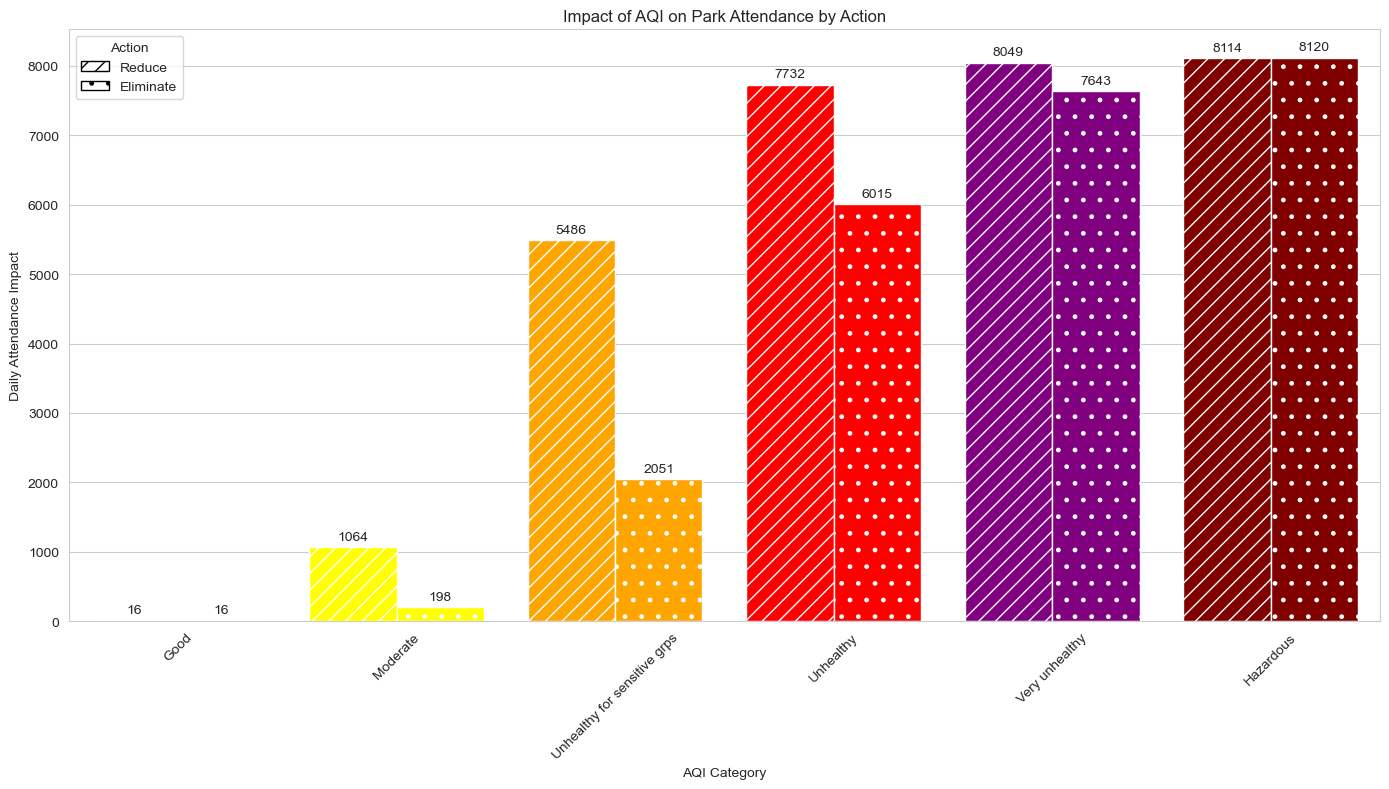

In [29]:
# Define color palette for AQI categories
aqi_palette = {
    "Good": "green",
    "Moderate": "yellow",
    "Unhealthy for sensitive grps": "orange",
    "Unhealthy": "red",
    "Very unhealthy": "purple",
    "Hazardous": "maroon"
}

# Define hatches for actions
hatches = {'Reduce': '//', 'Eliminate': '.'}

# Set up the figure
plt.figure(figsize=(14, 8))

# Create the barplot
axis = sns.barplot(
    x='AQI Category',
    y='daily_attendance_impact',
    hue='Action',
    data=activity_reduction_df,
    dodge=True
)

# Apply colors and hatches to bars
patch_index = 0
for index, row in activity_reduction_df.iterrows():
    bar_patch = axis.patches[patch_index]
    category = row['AQI Category']
    action = row['Action']

    # Set color and hatch
    bar_patch.set_facecolor(aqi_palette[category])
    bar_patch.set_hatch(hatches[action])

    patch_index += 1

# Add percentage labels above bars
for bar_container in axis.containers:
    axis.bar_label(bar_container, fmt='%.0f', label_type='edge', padding=3)

# Customize the plot
plt.xlabel('AQI Category')
plt.ylabel('Daily Attendance Impact')
plt.title('Impact of AQI on Park Attendance by Action')
plt.xticks(rotation=45)
plt.legend(title='Action', loc='upper right')

# Add custom legend for hatches
reduce_patch = mpatches.Patch(facecolor='white', edgecolor='black', hatch=hatches['Reduce'], label='Reduce')
eliminate_patch = mpatches.Patch(facecolor='white', edgecolor='black', hatch=hatches['Eliminate'], label='Eliminate')
plt.legend(handles=[reduce_patch, eliminate_patch], title='Action', loc='upper left')


# Display the plot and save the figure
plt.tight_layout()
file_path = 'Impact_of_aqi_on_park_attendance.png'
plt.savefig(file_path)

# Display the plot
plt.tight_layout()
plt.show()